# Download the Dataset

In [ ]:
from google.colab import files

! pip install -q kaggle
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
! kaggle datasets download -d amanneo/diabetic-retinopathy-resized-arranged -p ./data/ --unzip


100% 1.20G/1.21G [00:37<00:00, 42.3MB/s]
100% 1.21G/1.21G [00:37<00:00, 34.2MB/s]


In [ ]:
data_dir = './data'

# Create Image Data Generator to Augment the Image Data

In [ ]:
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.1,
    rotation_range=15,
    validation_split=0.2
)

In [ ]:
def make_train_val_generator(image_datagen, data_dir, img_shape, batch_size=32):
  train_generator = image_datagen.flow_from_directory(
      data_dir,
      target_size= img_shape,
      batch_size= batch_size,
      seed= 123,
      subset= 'training',
      class_mode= 'categorical')

  val_generator = image_datagen.flow_from_directory(
      data_dir,
      target_size= img_shape,
      batch_size= batch_size, 
      seed= 123,
      subset= 'validation',
      class_mode= 'categorical')
  
  return train_generator, val_generator

# Create Model 

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16  
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.densenet import DenseNet201  
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D

def create_model(transfer_model, img_shape):
    if (transfer_model == "DenseNet201"):
      base_model = DenseNet201(include_top= False, weights= "imagenet", input_shape= img_shape)
    elif (transfer_model == "Xception"):
      base_model = Xception(include_top= False, weights= "imagenet", input_shape= img_shape)
    elif (transfer_model == "MobileNetV2"):
      base_model = MobileNetV2(include_top= False, weights= "imagenet", input_shape= img_shape)
    else:
      base_model = VGG16(include_top= False, weights= "imagenet", input_shape= img_shape)
    
    base_model.trainable = False
    
    model = Sequential([
      base_model,
      GlobalAveragePooling2D(),
      Dropout(0.4),
      Dense(128, activation= 'relu'),
      Dense(5, activation= 'softmax')
    ])

    return model

In [ ]:
train_generator, val_generator = make_train_val_generator(image_datagen, data_dir, (224, 224), batch_size=128)

Found 28103 images belonging to 5 classes.
Found 7023 images belonging to 5 classes.


In [ ]:
train_generator


In [ ]:
mobilenet_model = create_model('MobileNetV2', (224, 224, 3))

9406464/9406464 [==============================] - 1s 0us/step


In [ ]:
mobilenet_model.compile(optimizer="adam", loss= 'categorical_crossentropy', metrics= ['accuracy'])


In [ ]:
mobilenet_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 2,422,597
Trainable params: 164,613
Non-tr

In [ ]:
epochs = 10
mobilenet_history = mobilenet_model.fit(
    x=train_generator, 
    validation_data=val_generator,
    epochs=epochs, 
    verbose=2, 
    validation_steps= None,
    shuffle= False,
)

Epoch 1/10
220/220 - 688s - loss: 0.8540 - accuracy: 0.7309 - val_loss: 0.8020 - val_accuracy: 0.7362 - 688s/epoch - 3s/step
Epoch 2/10
220/220 - 670s - loss: 0.8083 - accuracy: 0.7363 - val_loss: 0.7843 - val_accuracy: 0.7376 - 670s/epoch - 3s/step
Epoch 3/10
220/220 - 672s - loss: 0.7970 - accuracy: 0.7365 - val_loss: 0.7779 - val_accuracy: 0.7391 - 672s/epoch - 3s/step
Epoch 4/10
220/220 - 677s - loss: 0.7957 - accuracy: 0.7373 - val_loss: 0.7887 - val_accuracy: 0.7367 - 677s/epoch - 3s/step
Epoch 5/10
220/220 - 679s - loss: 0.7883 - accuracy: 0.7387 - val_loss: 0.7835 - val_accuracy: 0.7389 - 679s/epoch - 3s/step
Epoch 6/10
220/220 - 684s - loss: 0.7872 - accuracy: 0.7390 - val_loss: 0.7695 - val_accuracy: 0.7409 - 684s/epoch - 3s/step
Epoch 7/10
220/220 - 678s - loss: 0.7845 - accuracy: 0.7399 - val_loss: 0.7740 - val_accuracy: 0.7406 - 678s/epoch - 3s/step
Epoch 8/10
220/220 - 668s - loss: 0.7819 - accuracy: 0.7416 - val_loss: 0.7766 - val_accuracy: 0.7417 - 668s/epoch - 3s/step


# Plot Accuracy and Loss

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    Epochs = [i+1 for i in range(len(acc))]
    
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, acc, label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, loss, label= 'Training loss')
    plt.plot(Epochs, val_loss, label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label) 
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout
    plt.show()

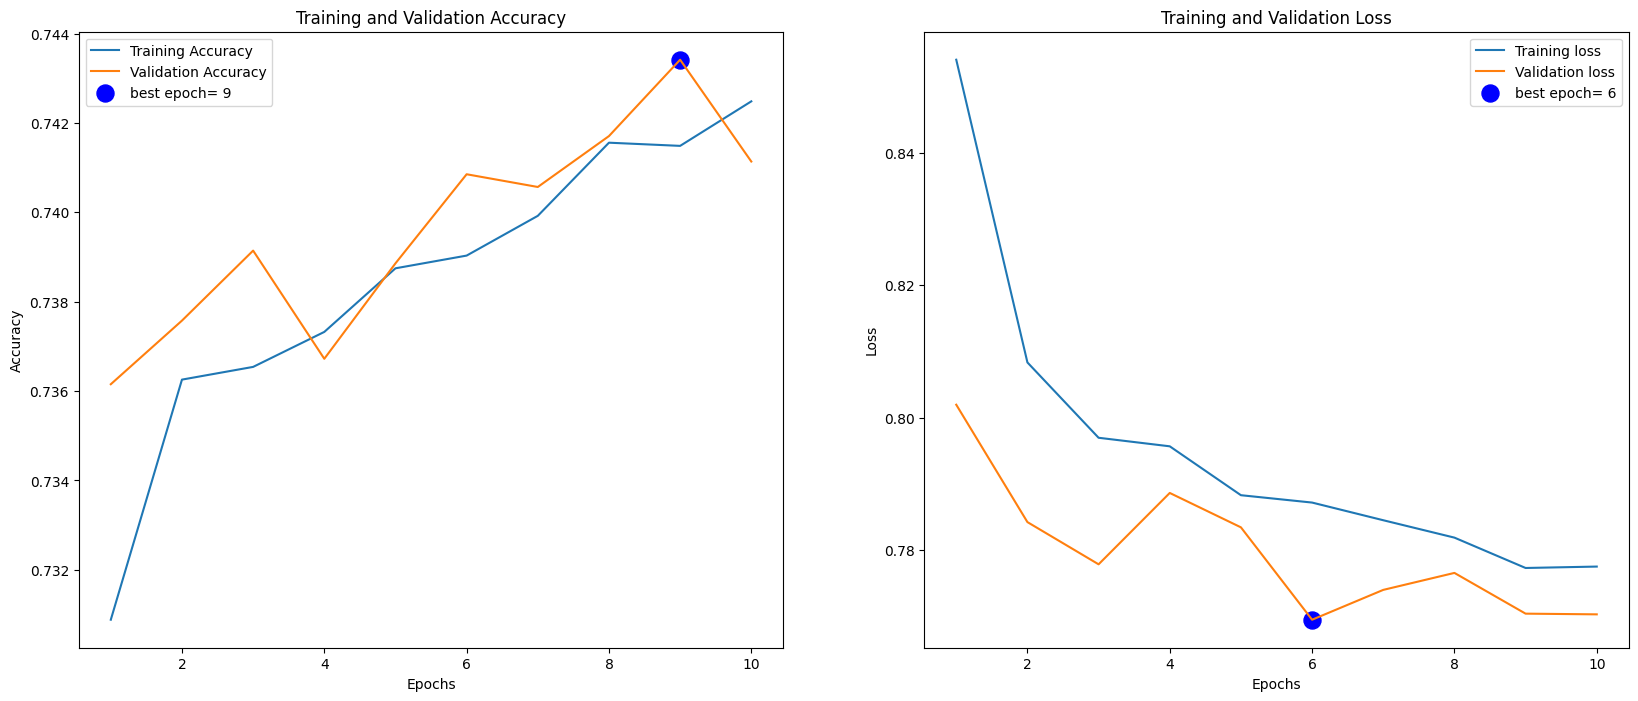

In [ ]:
plot_training(mobilenet_history)


# Test

In [ ]:
preds = mobilenet_model.predict(val_generator)
# preds = model.predict(test_generator)
y_pred = [np.argmax(y) for y in preds]
# print(y_pred)
print(preds)

55/55 [==============================] - 160s 3s/step
[[7.9873157e-01 7.9917289e-02 1.1031635e-01 6.0091279e-03 5.0257486e-03]
 [8.7694240e-01 5.4187354e-02 6.7765303e-02 9.8729471e-04 1.1771302e-04]
 [7.1145034e-01 8.4796339e-02 1.8012212e-01 2.0829894e-02 2.8013433e-03]
 ...
 [7.2366023e-01 6.2260248e-02 1.9960625e-01 1.0399957e-02 4.0732836e-03]
 [6.8285382e-01 7.0993647e-02 2.1886435e-01 1.9611888e-02 7.6762689e-03]
 [8.2658386e-01 8.8605657e-02 7.6758847e-02 6.5900134e-03 1.4615780e-03]]


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


def make_evaluation(test_gen, y_pred):
  classes = [label[:] for label in list(test_gen.class_indices.keys())] 
  class_count = len(classes)
  cm = confusion_matrix(test_gen.classes, y_pred)

  plt.figure(figsize=(12, 8))
  sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)     
  plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
  plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title("Confusion Matrix")
  plt.show()
  print("\nClassification Report:\n----------------------")
  print(classification_report(val_generator.classes, y_pred, target_names=classes))

make_evaluation(val_generator, y_pred)

# Save model

In [ ]:
mobilenet_model.save("model_mobilenet_dr.h5")

In [ ]:
import pickle

pickle.dump(mobilenet_model, open('model_mobilenet_dr.pkl', 'wb'))